In [1]:
#Create a model that takes a 20x20 image and is able to do INR on it. Try first just creating hyperresolution image of 40x40, then try to use techniques to aid with spectral bias
import pandas as pd
from PIL import Image
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import os
from einops import rearrange, repeat
import einops
from glob import glob
from math import log
import math
import kagglehub

In [5]:
###--- 1) Basics of Tensors ---###
#Tensor is basically an array with some dimension and shape, but unlike np arrays they can be moved to GPUs for ML
# and can be used for gradient tracking
#Uninitialized tensor with given shape, faster than initializing with 0 or 1
x = torch.empty(2, 3)
print(x)


x = torch.zeros(2, 3)
print(x)
x = torch.ones(2, 3)
print(x)

#we can specify data type of elements, float32 is the default for nn params
x = torch.rand(2, 3, dtype = torch.float32)
print(x)

tensor([[1.2640e-27, 4.5856e-41, 1.2639e-27],
        [4.5856e-41, 9.4075e-28, 4.5856e-41]])
tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([[1., 1., 1.],
        [1., 1., 1.]])
tensor([[0.0051, 0.3095, 0.6836],
        [0.3987, 0.1796, 0.5950]])


In [ ]:
#Tensor Operations
x, y = torch.rand(2,2)

#elementwise ops
print(x, y, x+y, x-y, x*y, x/y)

#slicing
z = torch.rand(6,3, 4)
print(z[:, 0]) # = z[:, 0, :]
print(z[:, 0, 2])
print(z[0, 2, 0].item())

In [ ]:
#Reshaping
x = torch.rand(4, 4)

# Changes the shape to whatever is specified
#-1 allows pytorch to determine the correct size to maintain same number of elements
print(x.view(-1))

print(x.view(8, -1))

#reshape does the same thing but either returns a view or copy of the data
print(x.reshape(8, -1))

In [ ]:
#Casting between array and tensor
x = torch.rand(3)
y = np.array(x) #or x.numpy()
z = torch.Tensor(y)

print(x, y, z)

In [32]:
#Moving between cpu and gpu
x = torch.rand(3)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("cuda available")
    x = x.to("cuda")
    print(x.device)
else:
    print("cuda unavailable; using cpu")


x =x.to("cpu")
print(x.device)

x = x.to(device)
print(x.device)

cuda available
cuda:0
cpu
cuda:0


In [ ]:
###--- 2) Autograd ---###
#from torchviz import make_dot
# keeps track of computational graph for us when we create tensors, streamlines backprop to calculate gradients
# which will be used in gradient update step using optim.step()

x = torch.rand(3, requires_grad = True)
w = torch.rand(2, 3, requires_grad = True)
b = torch.rand(2, requires_grad = True)
y = w@x + b
z = y.mean()

#dot = make_dot(z, params={'y': y, 'x': x})
#dot.format = 'png'
#dot.render('tensor_ops_graph')

z.backward()

print(w.grad)
print(b.grad)

In [7]:
import torchvision
import torchvision.transforms as transforms

In [57]:
batch_size = 128

train_dataset = torchvision.datasets.MNIST(root='./data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data/',
                                          train=False, 
                                          transform=transforms.ToTensor(),
                                         download=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 39.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.19MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.24MB/s]


In [55]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [79]:
type(train_dataset[5])

tuple

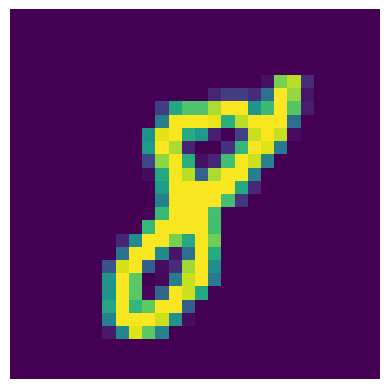

In [70]:
import matplotlib.pyplot as plt

train_image_zero, train_target_zero = train_dataset[17]

img = train_image_zero.detach().numpy()

img = np.transpose(img, (1, 2, 0))

plt.imshow(img)
plt.axis('off')
plt.show()

In [12]:
num_epochs = 5
num_classes = 10
learning_rate = 0.001

In [16]:
###--- x) Training a CNN-based model on MNIST ---###
import torch.nn as nn

#Define the model

class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [22]:
model = CNNModel(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader)
for epoch in range(num_epochs):
    model.train()
    
    for batch_num, (images, labels)  in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
         
        output = model(images)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch_num+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, batch_num+1, total_step, loss.item()))

#Training loop
#Learn early stopping, regularization

Epoch [1/5], Step [100/469], Loss: 0.1784
Epoch [1/5], Step [200/469], Loss: 0.0950
Epoch [1/5], Step [300/469], Loss: 0.0593
Epoch [1/5], Step [400/469], Loss: 0.0150
Epoch [2/5], Step [100/469], Loss: 0.0601
Epoch [2/5], Step [200/469], Loss: 0.0182
Epoch [2/5], Step [300/469], Loss: 0.0248
Epoch [2/5], Step [400/469], Loss: 0.0419
Epoch [3/5], Step [100/469], Loss: 0.0234
Epoch [3/5], Step [200/469], Loss: 0.0507
Epoch [3/5], Step [300/469], Loss: 0.0243
Epoch [3/5], Step [400/469], Loss: 0.0661
Epoch [4/5], Step [100/469], Loss: 0.0160
Epoch [4/5], Step [200/469], Loss: 0.0068
Epoch [4/5], Step [300/469], Loss: 0.0216
Epoch [4/5], Step [400/469], Loss: 0.0123
Epoch [5/5], Step [100/469], Loss: 0.0333
Epoch [5/5], Step [200/469], Loss: 0.0466
Epoch [5/5], Step [300/469], Loss: 0.0329
Epoch [5/5], Step [400/469], Loss: 0.0050


In [23]:
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model on the 10000 test images: 97.98 %


In [1]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub

# Download latest version
path = kagglehub.dataset_download("therealcyberlord/50k-celeba-dataset-64x64")

print("Path to dataset files:", path)

#Path to dataset files: /home/idies/.cache/kagglehub/datasets/therealcyberlord/50k-celeba-dataset-64x64/versions/1


/home/idies/workspace/Storage/tbalasoor/persistent/TestEnv2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 78.1M/78.1M [00:00<00:00, 88.0MB/s]

Extracting files...


Path to dataset files: /home/idies/.cache/kagglehub/datasets/therealcyberlord/50k-celeba-dataset-64x64/versions/1


In [1]:
#CelebA HQ
import kagglehub
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)
#Path to dataset files: /home/idies/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba/img_align_celeba

100%|██████████| 1.33G/1.33G [00:19<00:00, 73.5MB/s]

Extracting files...


Path to dataset files: /home/idies/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


In [2]:
import os
from torchvision.datasets import CIFAR10
from torchvision.utils import save_image
from torchvision import transforms
from tqdm import tqdm

# Output folder
output_dir = '/home/idies/.cache/cifar-10'
os.makedirs(output_dir, exist_ok=True)

# Transformation
to_tensor = transforms.ToTensor()

# Download CIFAR-10
train_set = CIFAR10(root=output_dir, train=True, download=True)
test_set = CIFAR10(root=output_dir, train=False, download=True)

# Save all images from train (0 to 49999)
for i, (img, _) in tqdm(enumerate(train_set), total=len(train_set), desc="Saving train"):
    save_image(to_tensor(img), os.path.join(output_dir, f"{i:06d}.jpg"))

# Save all images from test (50000 to 59999)
for i, (img, _) in tqdm(enumerate(test_set), total=len(test_set), desc="Saving test"):
    idx = i + len(train_set)
    save_image(to_tensor(img), os.path.join(output_dir, f"{idx:06d}.jpg"))

100%|██████████| 170M/170M [00:01<00:00, 89.4MB/s] 
Saving test: 100%|██████████| 10000/10000 [00:04<00:00, 2343.93it/s]


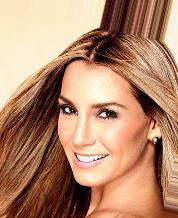

000001.jpg


In [6]:
path = '/home/idies/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba/img_align_celeba'
from PIL import Image


i = 0 
for f in os.listdir(str(path)):
    if i > 0:
        break
    i+=1
    with Image.open(str(path)+'/'+str(f)) as img:
                    img.show()
    print(f)


In [40]:
class Celeba(Dataset):

    def __init__(self, root_path, split, resize = 64):
        self.data = glob(os.path.join(root_path, "*.jpg"))
        if split == 'train':
            self.data = self.data[:40000]
        elif split == 'val':
            self.data = self.data[40001:45000]
        elif split == 'test':
            self.data = self.data[45001:50000]

        self.transform = transforms.Compose([
            transforms.Resize(resize),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
        ])
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        x = self.transform(img)
        return {'inp': x, 'gt': x}
        
dataset = Celeba(path, 'test')

In [36]:
def get_coord_grid(h, w, device):
    y, x = torch.meshgrid(
        torch.linspace(-1, 1, steps=h, device=device),
        torch.linspace(-1, 1, steps=w, device=device),
        indexing='ij'
    )
    coords = torch.stack([x, y], dim=-1)  # (H, W, 2)
    return coords.view(-1, 2)  # (H*W, 2)
H, W = 64, 64
B = 1
coords = get_coord_grid(H, W, device).unsqueeze(0).repeat(B, 1, 1)  # (B, H*W, 2)
print(coords.shape)

torch.Size([1, 4096, 2])
